In [2]:
import pandas as pd
import spacy
import numpy as np
import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
# Load the training data
train_data = pd.read_csv('data/train.csv')

# Display first few rows to understand the data
train_data.head()

,Sentence_id,Text,Verdict
0,1,I think we've seen a deterioration of values.,-1
1,2,I think for a while as a nation we condoned th...,-1
2,3,"For a while, as I recall, it even seems to me ...",-1
3,4,"So we've seen a deterioration in values, and o...",-1
4,5,"We got away, we got into this feeling that val...",-1


In [4]:
# Split data into features and target
X = train_data['Text']
y = train_data['Verdict']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_val.shape)

Train shape: (20250,) Test shape: (2251,)


In [5]:
from collections import Counter


nlp = spacy.load("en_core_web_md")

class EnhancedNLPFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.entity_types = None  # Store entity types seen in training
        self.dependency_types = None  # Store dependency types
        
    def fit(self, X, y=None):
        """Collects all entity types and dependency labels present in the training data."""
        entity_types_set = set()
        dependency_types_set = set()
        
        for text in X:
            doc = nlp(text)
            # Collect entity types
            for ent in doc.ents:
                entity_types_set.add(ent.label_)
            
            # Collect dependency types
            for token in doc:
                dependency_types_set.add(token.dep_)
                
        self.entity_types = sorted(entity_types_set)  # Sort to ensure consistent order
        self.dependency_types = sorted(dependency_types_set)
        return self
    
    def transform(self, X, y=None):
        """Extracts all NLP features."""
        syntactic_features = self._extract_syntactic_features(X)
        entity_features = self._extract_entity_features(X)
        dependency_features = self._extract_dependency_features(X)
        semantic_features = self._extract_semantic_features(X)
        
        # Combine all feature sets
        all_features = np.hstack((
            syntactic_features, 
            entity_features, 
            dependency_features,
            semantic_features,
        ))
        
        return all_features
    
    def _extract_syntactic_features(self, X):
        """Extract syntactic features from texts."""
        features = []
        for text in X:
            doc = nlp(text)
            sentence_length = len(doc)
            safe_divisor = max(1, sentence_length)  # Avoid division by zero
            
            # Basic syntactic features
            punctuation_count = sum(1 for token in doc if token.text in string.punctuation) / safe_divisor
            
            # POS features with normalization
            pos_counts = Counter([token.pos_ for token in doc])
            noun_count = pos_counts.get("NOUN", 0) / safe_divisor
            verb_count = pos_counts.get("VERB", 0) / safe_divisor
            adj_count = pos_counts.get("ADJ", 0) / safe_divisor
            adv_count = pos_counts.get("ADV", 0) / safe_divisor
            pron_count = pos_counts.get("PRON", 0) / safe_divisor
            det_count = pos_counts.get("DET", 0) / safe_divisor
            
            # Stopwords and punctuation
            stopword_count = sum(token.is_stop for token in doc) / safe_divisor
            
            # Sentence structure features
            avg_token_length = sum(len(token.text) for token in doc) / safe_divisor
            uppercase_ratio = sum(1 for token in doc if token.text.isupper()) / safe_divisor
            
            # Sentence count
            sentence_count = len(list(doc.sents))
            avg_words_per_sentence = sentence_count > 0 and sentence_length / sentence_count or 0
            
            features.append([
                sentence_length,
                sentence_count,
                avg_words_per_sentence,
                punctuation_count,
                noun_count,
                verb_count,
                adj_count,
                adv_count,
                pron_count,
                det_count,
                stopword_count,
                avg_token_length,
                uppercase_ratio
            ])
        return np.array(features)
    
    def _extract_entity_features(self, X):
        """Extract named entity features from texts."""
        features = []
        entity_types_list = self.entity_types or []  # Use stored entity types
        
        if not entity_types_list:  # Handle case where no entities were found during fit
            return np.zeros((len(X), 1))

        for text in X:
            doc = nlp(text)
            total_entities = len(doc.ents)
            safe_divisor = max(1, total_entities)  # Avoid division by zero
            
            # Entity type distributions
            type_counts = {etype: 0 for etype in entity_types_list}
            for ent in doc.ents:
                if ent.label_ in type_counts:
                    type_counts[ent.label_] += 1
            
            # Normalized entity counts
            normalized_counts = [type_counts[etype] / safe_divisor for etype in entity_types_list]
            
            # Entity density (entities per token)
            entity_density = total_entities / max(1, len(doc))
            
            # Entity length features
            entity_lengths = [len(ent) for ent in doc.ents]
            avg_entity_length = sum(entity_lengths) / safe_divisor if entity_lengths else 0
            
            feature_row = [total_entities, entity_density, avg_entity_length] + normalized_counts
            features.append(feature_row)

        return np.array(features)
    
    def _extract_dependency_features(self, X):
        """Extract dependency parsing features from texts."""
        features = []
        dependency_types_list = self.dependency_types or []
        
        if not dependency_types_list:
            return np.zeros((len(X), 1))
            
        for text in X:
            doc = nlp(text)
            token_count = len(doc)
            safe_divisor = max(1, token_count)
            
            # Dependency type distributions
            dep_counts = {dep: 0 for dep in dependency_types_list}
            for token in doc:
                if token.dep_ in dep_counts:
                    dep_counts[token.dep_] += 1
            
            # Normalized dependency counts
            normalized_deps = [dep_counts[dep] / safe_divisor for dep in dependency_types_list]
            
            # Tree complexity features
            root_count = sum(1 for token in doc if token.dep_ == "ROOT")
            avg_children = sum(len(list(token.children)) for token in doc) / safe_divisor
            max_depth = self._find_max_tree_depth(doc)
            
            feature_row = [root_count, avg_children, max_depth] + normalized_deps
            features.append(feature_row)
            
        return np.array(features)
    
    def _find_max_tree_depth(self, doc):
        """Calculate the maximum depth of the dependency tree."""
        if not doc:
            return 0
            
        def get_depth(token):
            if not list(token.children):
                return 0
            return 1 + max(get_depth(child) for child in token.children)
            
        roots = [token for token in doc if token.dep_ == "ROOT"]
        if not roots:
            return 0
            
        return max(get_depth(root) for root in roots)
    
    def _extract_semantic_features(self, X):
        """Extract semantic features from the text."""
        features = []
        
        for text in X:
            doc = nlp(text)
            token_count = len(doc)
            safe_divisor = max(1, token_count)
            
            # Vector statistics (if available)
            has_vectors = sum(token.has_vector for token in doc)
            vector_ratio = has_vectors / safe_divisor
            
            # Semantic similarity features
            # Average similarity between consecutive tokens
            consecutive_similarities = []
            for i in range(len(doc) - 1):
                if doc[i].has_vector and doc[i+1].has_vector:
                    consecutive_similarities.append(doc[i].similarity(doc[i+1]))
                    
            avg_similarity = sum(consecutive_similarities) / max(1, len(consecutive_similarities)) if consecutive_similarities else 0
            
            # Extract lexical cohesion based on lemmas
            unique_lemmas = set(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)
            lemma_ratio = len(unique_lemmas) / safe_divisor if unique_lemmas else 0
            
            features.append([
                vector_ratio,
                avg_similarity,
                lemma_ratio
            ])
            
        return np.array(features)


# Combine TF-IDF features with syntactic and named entity features
combined_features = FeatureUnion([
    ('tfidf', TfidfVectorizer(max_features=25000, ngram_range=(1, 3))),
    ('syntactic', EnhancedNLPFeatureExtractor()),
])

In [6]:
X_train_combined_features = combined_features.fit_transform(X_train)
X_val_combined_features = combined_features.transform(X_val)


In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_combined_features_oversampled, y_train_oversampled = smote.fit_resample(X_train_combined_features, y_train)
smote_class_counts = y_train_oversampled.value_counts().sort_index()
print(f"Class -1: {smote_class_counts.get(-1, 0)} samples")
print(f"Class 0: {smote_class_counts.get(0, 0)} samples")
print(f"Class 1: {smote_class_counts.get(1, 0)} samples")

Class -1: 13234 samples
Class 0: 13234 samples
Class 1: 13234 samples


In [ ]:
# from imblearn.under_sampling import RandomUnderSampler

# undersampler = RandomUnderSampler(random_state=42)
# X_train_combined_features_undersampled, y_train_undersampled = undersampler.fit_resample(X_train_combined_features, y_train)

# # Count the number of samples in each class after undersampling
# undersample_class_counts = y_train_undersampled.value_counts().sort_index()
# print(f"Class -1: {undersample_class_counts.get(-1, 0)} samples")
# print(f"Class 0: {undersample_class_counts.get(0, 0)} samples")
# print(f"Class 1: {undersample_class_counts.get(1, 0)} samples")

Class -1: 1901 samples
Class 0: 1901 samples
Class 1: 1901 samples


In [ ]:
y_train_mapped = y_train_oversampled.values + 1
y_val_mapped = y_val.values + 1

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter distribution
param_dist = {
    'num_leaves': randint(20, 150),
    'max_depth': [-1, 10, 20, 30],
    'min_split_gain': [0.01, 0.1],
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(100, 1000),
    'min_child_samples': randint(1, 10),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Initialize the LightGBM classifier
lgbm = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42, class_weight='balanced')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=100, scoring='f1_macro', cv=3, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train_combined_features_oversampled, y_train_mapped)

# Retrieve the best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

# lgb_direct = lgb.LGBMClassifier(
#     objective='multiclass',
#     num_class=3,
#     learning_rate=0.05,
#     max_depth=12,
#     min_split_gain=0.1,
#     min_child_samples=5,
#     # subsample=0.8,
#     # colsample_bytree=0.8,
#     # reg_alpha=0.1,
#     # reg_lambda=0.1,
#     random_state=42,
#     n_estimators=500,
#     class_weight='balanced',
#     # Specify class weights based on ratio 14:6:2
#     # class_weight={0: 0.214, 1: 0.5, 2: 1.5},  # Inversely proportional to class frequency
#     # is_unbalance=False,  # Don't use the automatic unbalance handling (we have custom weights)
#     verbose=1
# )
# lgb_direct.fit(X_train_combined_features_oversampled, y_train_mapped)


In [9]:
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

Best Parameters: {'colsample_bytree': 0.9887783209121515, 'learning_rate': 0.10442515971251674, 'max_depth': 30, 'min_child_samples': 4, 'min_split_gain': 0.1, 'n_estimators': 789, 'num_leaves': 143, 'reg_alpha': 0.12850035323391018, 'reg_lambda': 0.811204176736003, 'subsample': 0.9641278951487912}
Best Cross-Validation Accuracy: 0.8481


In [11]:
lgbm = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3, 
    random_state=42, 
    class_weight='balanced',
    colsample_bytree=0.9887783209121515,
    learning_rate=0.10442515971251674, 
    max_depth=30,
    min_child_samples=4,
    min_split_gain=0.1,
    n_estimators=789,
    num_leaves=143,
    reg_alpha=0.12850035323391018, 
    reg_lambda=0.811204176736003,
    subsample=0.9641278951487912    
)
lgbm.fit(X_train_combined_features_oversampled, y_train_mapped)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.861084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450240
[LightGBM] [Info] Number of data points in the train set: 39702, number of used features: 24942
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

LGBMClassifier(class_weight='balanced', colsample_bytree=0.9887783209121515,
               learning_rate=0.10442515971251674, max_depth=30,
               min_child_samples=4, min_split_gain=0.1, n_estimators=789,
               num_class=3, num_leaves=143, objective='multiclass',
               random_state=42, reg_alpha=0.12850035323391018,
               reg_lambda=0.811204176736003, subsample=0.9641278951487912)

Accuracy on the validation set: 77.34%
Macro F1 Score: 0.6413
F1 Score per class: [0.8629111  0.4173028  0.64354528]
Confusion matrix saved as 'confusion_matrix.png'


/Users/anc/Library/CloudStorage/OneDrive-Personal/Desktop/NUS/Modules/Y4S2/CS4248/A2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


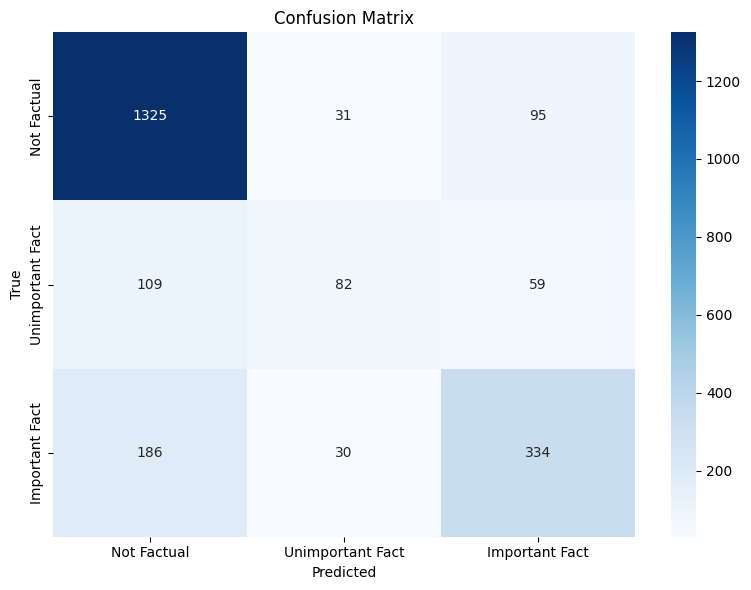

In [12]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

y_val_pred = lgbm.predict(X_val_combined_features) # using 10k features from tfidf

# Evaluate the model
accuracy = accuracy_score(y_val_mapped, y_val_pred)
f1 = f1_score(y_val_mapped, y_val_pred, average='macro')
f1_per_class = f1_score(y_val_mapped, y_val_pred, average=None)

print(f'Accuracy on the validation set: {accuracy * 100:.2f}%')
print(f'Macro F1 Score: {f1:.4f}')
print(f'F1 Score per class: {f1_per_class}')

# Create and plot confusion matrix
cm = confusion_matrix(y_val_mapped, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

In [ ]:
import joblib

pipeline = Pipeline([
    ('features', combined_features),
    ('lgb_direct', lgbm)
])
joblib.dump(pipeline, 'models/new_features_tfidf25k_lgb_hyperparam_tuned_model.pkl')
print("Model saved as 'models/new_features_tfidf25k_lgb_hyperparam_tuned_model.pkl'")

Model saved as 'models/new_features_tfidf25k_lgb_hyperparam_tuned_model.pkl'


In [15]:
pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tfidf',
                                                 TfidfVectorizer(max_features=25000,
                                                                 ngram_range=(1,
                                                                              3))),
                                                ('syntactic',
                                                 EnhancedNLPFeatureExtractor())])),
                ('lgb_direct',
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.9887783209121515,
                                learning_rate=0.10442515971251674, max_depth=30,
                                min_child_samples=4, min_split_gain=0.1,
                                n_estimators=789, num_class=3, num_leaves=143,
                                objective='multiclass', random_state=42,
                                reg_alpha=0.12850035323391018,
                                reg_lambda=0.811204176736003,
                                subsample=0.9641278951487912))])

In [14]:

# Function to make predictions on test data
def predict_test_data(model_path, test_path, output_path):
    # Load the model and test data
    model = joblib.load(model_path)
    test_data = pd.read_csv(test_path)
    
    # Make predictions
    predictions = model.predict(test_data['Text'])
    
    # Create output DataFrame
    output_df = pd.DataFrame({
        'Sentence_id': test_data['Sentence_id'],
        'Verdict': predictions - 1
    })
    
    # Save to CSV
    output_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")


print("\nMaking predictions on test data...")
predict_test_data('models/new_features_tfidf25k_lgb_hyperparam_tuned_model.pkl', 'data/test.csv', 'data/new_features_tfidf25k_lgb_hyperparam_tuned_predictions.csv')


Making predictions on test data...
Predictions saved to data/new_features_tfidf25k_lgb_hyperparam_tuned_predictions.csv


/Users/anc/Library/CloudStorage/OneDrive-Personal/Desktop/NUS/Modules/Y4S2/CS4248/A2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
